In [1]:
!git clone https://github.com/nickgentoo/ForgedHandwritingVerification


Cloning into 'ForgedHandwritingVerification'...
remote: Enumerating objects: 6588, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 6588 (delta 0), reused 6 (delta 0), pack-reused 6582
Receiving objects: 100% (6588/6588), 410.28 MiB | 24.32 MiB/s, done.
Updating files: 100% (6641/6641), done.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [3]:
import torch.nn.functional as F


class ForgerySiameseDataset(Dataset):
    def __init__(self, root_folder, transform=None):
        self.root_dir = root_folder
        self.transform = transform
        self.image_names = os.listdir(root_folder)
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        base_name, extension = os.path.splitext(image_name)
        parts = base_name.split('_')
        label = 1 if 'G' in parts else 0
        opposite_label = 'F'
        opposite_name = f"{parts[0]}_{opposite_label}_{parts[2]}{extension}"

        # Load images
        image_path = os.path.join(self.root_dir, image_name)
        opposite_path = os.path.join(self.root_dir, opposite_name)

        image = Image.open(image_path).convert('L')
        opposite_image = Image.open(opposite_path).convert('L')
        if self.transform:
            image = self.transform(image)
            opposite_image = self.transform(opposite_image)
            
        label = torch.tensor((label), dtype=torch.float32)

        return image,opposite_image,label

    def __len__(self):
        return len(self.image_names)

# Define a Siamese network
# (Use the SiameseNetwork and ContrastiveLoss classes from the previous example)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
# Load the dataset
dataset = ForgerySiameseDataset(root_folder='/kaggle/working/ForgedHandwritingVerification/ForgedHandwritingVerification_copy', transform=transform)

# Create data loader
train_dataloader = DataLoader(dataset, shuffle=True, batch_size=64)


In [4]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.convolutional_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(128, 256, kernel_size=3),
            nn.LeakyReLU(inplace=True),
            nn.AdaptiveMaxPool2d((1, 1))  
        )

        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.LeakyReLU(inplace=True),
            nn.Linear(128, 1)
        )

    def forward_one(self, x):
        x = self.convolutional_layers(x)
        x = x.view(x.size()[0], -1)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        distance = torch.abs(output1 - output2)
        distance = self.fc(distance)
        sig = nn.Sigmoid()
        distance = sig(distance)
        
        return distance.squeeze(1)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

In [7]:
from tqdm import tqdm


siamese_network = SiameseNetwork()
siamese_network = siamese_network.to(device)
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss
# Define optimizer
optimizer = torch.optim.Adam(siamese_network.parameters(),lr=0.001)
#num_epochs = 20
num_epochs = 5
# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0
    for i, data in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        outputs = siamese_network(data[0].cuda(), data[1].cuda())
        loss = criterion(outputs, data[2].cuda())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()  # Accumulate the loss

    average_loss = total_loss / len(train_dataloader)  # Calculate average loss for the epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}')


# Save the trained model
torch.save(siamese_network.state_dict(), 'forgery_detection_model.pth')


100%|██████████| 52/52 [01:01<00:00,  1.18s/it]


Epoch [1/5, Loss: 0.6552


100%|██████████| 52/52 [00:55<00:00,  1.07s/it]


Epoch [2/5, Loss: 0.5881


100%|██████████| 52/52 [00:54<00:00,  1.06s/it]


Epoch [3/5, Loss: 0.5342


100%|██████████| 52/52 [00:54<00:00,  1.06s/it]


Epoch [4/5, Loss: 0.5141


100%|██████████| 52/52 [00:55<00:00,  1.06s/it]

Epoch [5/5, Loss: 0.5085


In [8]:
# Save the trained model
torch.save(siamese_network.state_dict(), 'forgery_detection_model')

In [9]:
genuine_image_path = '/kaggle/working/ForgedHandwritingVerification/ForgedHandwritingVerification_copy/T10_G_7.jpg' 
forged_image_path = '/kaggle/working/ForgedHandwritingVerification/ForgedHandwritingVerification_copy/T10_G_7.jpg'

img1 = transform(Image.open(genuine_image_path).convert("L")).unsqueeze(0).cuda()  # Convert to grayscale
img2 = transform(Image.open(forged_image_path).convert("L")).unsqueeze(0).cuda() 

print(img1.shape,img1.shape)

torch.Size([1, 1, 224, 224]) torch.Size([1, 1, 224, 224])


In [10]:
print(siamese_network(img2,img1).cpu().detach().numpy())

[0.01583704]


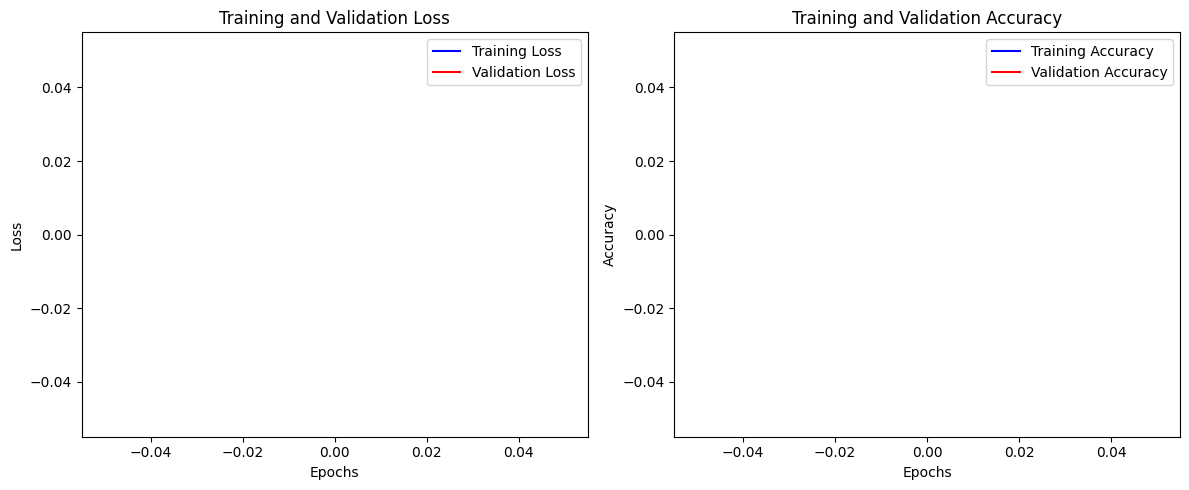

In [11]:
# Plotting
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(valid_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
pip install torchsummary

In [ ]:
from torchsummary import summary

# Initialize an instance of the SiameseNetwork
siamese_network = SiameseNetwork()

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
siamese_network = siamese_network.to(device)

# Print the model summary
summary(siamese_network, [(1, 224, 224), (1, 224, 224)])
